In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import os
import time

from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization, Dropout, LeakyReLU
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError
from keras import activations

from sklearn.preprocessing import MinMaxScaler
from astroNN.datasets import load_galaxy10

from tensorflow.keras import utils
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1922659417438655971
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4772069376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8560587639904246472
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [3]:
import tensorflow as tf
print(tf.__version__)

2.12.1


In [ ]:
# with h5py.File('Galaxy10_DECals.h5', 'r') as h5_file:
#     # Odczytaj dane ze zbiorów danych
#     ans_data = h5_file['ans'][:]
#     dec_data = h5_file['dec'][:]
#     images_data = h5_file['images'][:]
#     pxscale_data = h5_file['pxscale'][:]
#     ra_data = h5_file['ra'][:]
#     redshift_data = h5_file['redshift'][:]

# # Tworzenie DataFrame z danymi
# data_dict = {
#     'ans': ans_data,
#     'dec': dec_data,
#     'images': images_data,
#     'pxscale': pxscale_data,
#     'ra': ra_data,
#     'redshift': redshift_data
# }

# df = pd.DataFrame(data_dict)

In [2]:
%%time
# # To get the images and labels from file
with h5py.File('../Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.uint8)
images = images.astype(np.float32)
labels_names = ["Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies",
            "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", "Edge-on Galaxies with Bulge"]

CPU times: user 49.3 s, sys: 42.7 s, total: 1min 32s
Wall time: 1min 57s


In [3]:
# images = list(np.array_split(images, 1024))

def genenerator():
    for i in images:
        yield i

In [4]:
data_flow = tf.data.Dataset.from_generator(genenerator, tf.float32, output_shapes=(256,256,3))

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def custom_preprocessing(x):
    x = tf.image.rgb_to_grayscale(x)  # Convert to grayscale
    # print(x.shape)
    # x = tf.image.resize(x, (64, 64))  # Resize to 64x64
    # print(x.shape)
    return x

data_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    rescale=1.0/127.5 - 1.0 
)

batch_size = 32

data_flow = data_generator.flow(
    images,
    batch_size=batch_size,
    shuffle=True
)

In [5]:
%%time
# images = tf.data.Dataset.from_tensor_slices(images)

def resize_data(image):
  SIZE = (64, 64)
  image = tf.image.resize(image, SIZE)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0
  return image
  

data_flow = data_flow.map(resize_data)

Cause: Unable to locate the source code of <function resize_data at 0x7fe7e1f29a60>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function resize_data at 0x7fe7e1f29a60>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @t

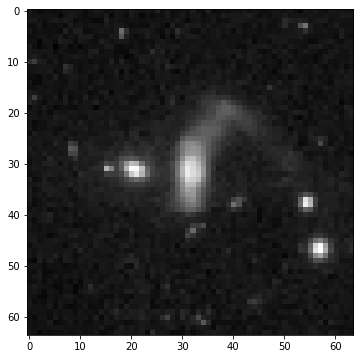

In [6]:
iterator = iter(data_flow)

plt.figure(figsize=(10, 6))
plt.imshow(next(iterator).numpy().astype(np.float32), cmap="gray")

In [7]:
for name, count in zip(labels_names, np.unique(labels[:,:], axis=0, return_counts=True)[1]):
    print(f"{name}: {count}")

Disturbed Galaxies: 1873
Merging Galaxies: 1423
Round Smooth Galaxies: 2628
In-between Round Smooth Galaxies: 1829
Cigar Shaped Smooth Galaxies: 2043
Barred Spiral Galaxies: 334
Unbarred Tight Spiral Galaxies: 2027
Unbarred Loose Spiral Galaxies: 2645
Edge-on Galaxies without Bulge: 1853
Edge-on Galaxies with Bulge: 1081


In [8]:
def show_image(index):
    plt.figure(figsize=(10, 6))
    plt.imshow(images[index].astype(np.int16), cmap="gray")
    plt.title(labels_names[np.where(labels[index] == 1)[0][0]])
    print(labels[index])
    plt.show()


show_image(13)

TypeError: '_TensorSliceDataset' object is not subscriptable

<Figure size 720x432 with 0 Axes>

In [13]:
scaler = MinMaxScaler()
images = scaler.fit_transform(images.reshape(-1, 64*64))
images = images * 2 - 1
images = images.reshape(-1, 64, 64)

In [15]:
BUFFER_SIZE = 17736
BATCH_SIZE = 16

# Batch and shuffle the data
data_flow = data_flow.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Model

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = Sequential([
    Dense(4 * 4 * 512, input_shape=[codings_size,]),
    Reshape([4, 4, 512]),
    BatchNormalization(),
    Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding="same", activation="tanh"),
])

discriminator = Sequential([
    Conv2D(filters=64, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2), input_shape=[64, 64, 1]),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=4, strides=2, padding="same", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Flatten(),
    Dense(1, activation="sigmoid")
])



In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        4194816   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                        

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 256)       

In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5, beta_2=0.999)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [9]:
EPOCHS = 50
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, codings_size])

In [10]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, codings_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [11]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,epochs,seed)

In [12]:
def generate_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  
  plt.show()

In [ ]:
%%time
time.sleep(5)
train(images, 2)

In [13]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        images: 13.0 GiB
                        labels: 173.3 KiB
                           _i7:  1.3 KiB
                         Model:  1.0 KiB
                     MaxPool2D:  1.0 KiB
                       Dropout:  1.0 KiB
                          Adam:  1.0 KiB
                           SGD:  1.0 KiB
              MeanSquaredError:  1.0 KiB
                  MinMaxScaler:  1.0 KiB
